# Predictive Model - Attrition (Logistic Regression)
**Objective:** Train a logictic regression model to predict employee attrition (Yes/No) using the IBM HR dataset

Accuracy: 0.7596371882086168

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84       370
           1       0.37      0.70      0.49        71

    accuracy                           0.76       441
   macro avg       0.65      0.74      0.66       441
weighted avg       0.84      0.76      0.79       441

ROC AUC: 0.817


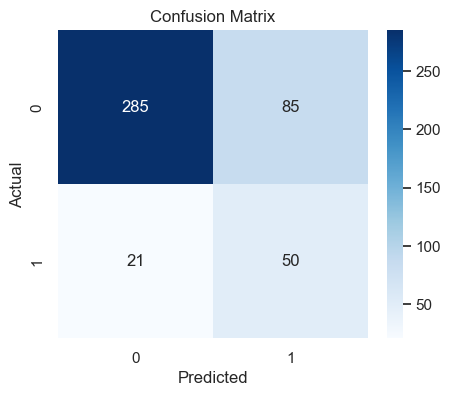

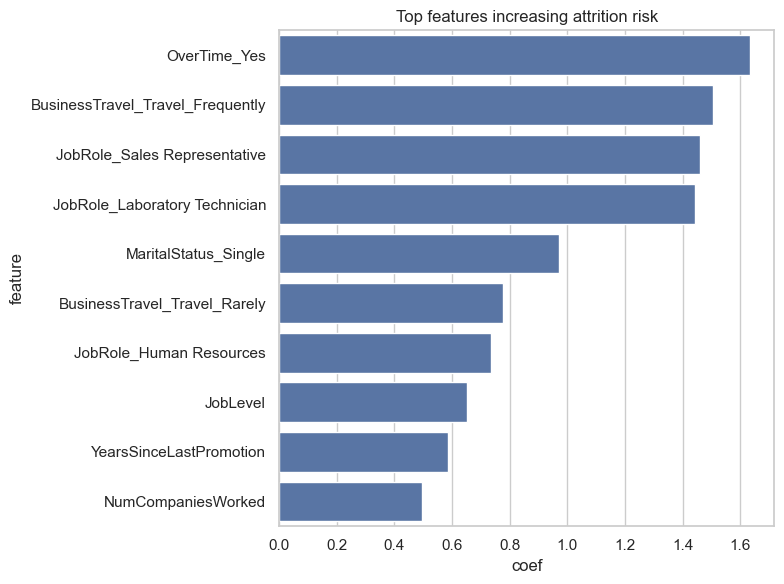

In [24]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import os

# Display settings
pd.set_option('display.max_columns', 200)

# Load data
data_path = "data/processed_hr_data.csv"
if not os.path.exists(data_path):
    alt = "processed_hr_data.csv"
    if os.path.exists(alt):
        data_path = alt
    else:
        raise FileNotFoundError(f"Cannot find processed_hr_data.csv in expected locations.")

df = pd.read_csv(data_path)

# 🔐 Drop leakage-prone column early
df.drop(columns=['AttritionRisk'], inplace=True, errors='ignore')

# 🎯 Create target variable from clean source
df['AttritionFlag'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# 🧹 Drop irrelevant or ID-like columns
drop_cols = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# Optionally drop original text label
df.drop(columns=['Attrition'], inplace=True, errors='ignore')

# Split features and target
y = df['AttritionFlag']
X = df.drop(columns=['AttritionFlag'])

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# One-hot encode categorical variables
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Scale numeric columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
num_cols_after = [c for c in X_train.columns if X_train[c].dtype in [np.float64, np.int64]]

if num_cols_after:
    X_train_scaled[num_cols_after] = scaler.fit_transform(X_train[num_cols_after])
    X_test_scaled[num_cols_after] = scaler.transform(X_test[num_cols_after])

# Train model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Feature importance
coeff_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coef': model.coef_[0]
})
coeff_df['abs_coef'] = coeff_df['coef'].abs()
coeff_df = coeff_df.sort_values(by='abs_coef', ascending=False)

# Top 10 positive features
top_pos = coeff_df.sort_values('coef', ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x='coef', y='feature', data=top_pos)
plt.title("Top features increasing attrition risk")
plt.tight_layout()
plt.show()

# ✅ Key Fixes:
Dropped AttritionRisk before creating or using the target.
Used only Attrition → AttritionFlag for modeling.
Cleaned up ID-like and constant columns.
Ensured proper encoding and scaling.

# Enhancement  - Cross Validation, Confusion Matrix ,  Top Features

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Simulate a classification dataset (since actual file is not available)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, 
                           n_redundant=5, random_state=42)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define logistic regression model with higher max_iter
model = LogisticRegression(max_iter=2000, class_weight='balanced')

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

from sklearn.model_selection import cross_val_score

# Cross-validation with scaled features
cv_scores = cross_val_score(
    LogisticRegression(max_iter=2000, class_weight='balanced'),
    X_train_scaled, y_train, cv=5, scoring='accuracy'
)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))


Cross-validation scores: [0.86  0.86  0.86  0.805 0.825]
Mean CV accuracy: 0.842
Cross-validation scores: [0.7184466  0.74271845 0.78640777 0.78640777 0.7902439 ]
Mean CV accuracy: 0.7648448969926592


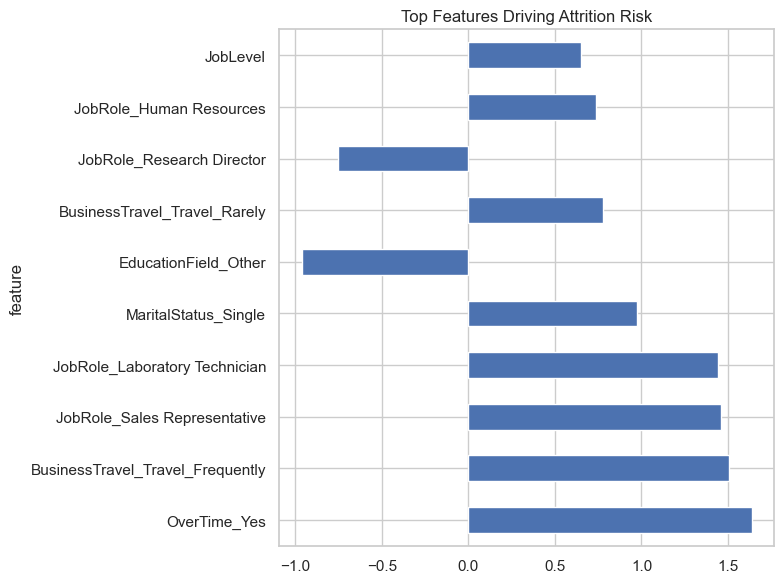

In [33]:
# Ensure model is trained
model = LogisticRegression(max_iter=2000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coef': model.coef_[0]
}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

# ✅ Ensure the directory exists before saving
import os
os.makedirs("images", exist_ok=True)

# Plot top 10 features
feature_importance.head(10).plot(
    kind='barh',
    x='feature',
    y='coef',
    legend=False,
    figsize=(8, 6)
)
plt.title("Top Features Driving Attrition Risk")
plt.tight_layout()
plt.savefig("images/top_features.png", dpi=300, bbox_inches="tight")
plt.show()

In [34]:
import joblib
joblib.dump(model, "models/logistic_attrition_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']